In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import cvxpy as cx

In [0]:
def aloca(entregadores, disponiveis, pedido):
    distancias = dist.cdist(entregadores[disponiveis, :], [pedido], metric="cityblock").T
    escolhido = (np.array(range(len(entregadores)))[disponiveis])[distancias.argmin()]
    disponiveis[escolhido] = False
    return escolhido, distancias.min()

def mostraAlocado1(entregadores, pedidos, alocados, pedido):
    entregador = entregadores[int(alocados[pedido, 0])]

    disponiveis = np.array([False if i in alocados[:pedido, 0] else True for i in range(nEntregadores)])

    plt.scatter(*(entregadores[disponiveis, :].T))
    plt.scatter(*(pedidos[pedido, :].T), marker='x')

    plt.plot([entregador[0], entregador[0]], [entregador[1], pedidos[pedido, 1]], 'g')
    plt.plot([entregador[0], pedidos[pedido, 0]], [pedidos[pedido, 1], pedidos[pedido, 1]], 'g')

    plt.xticks(range(-20, 20))
    plt.yticks(range(-20, 20))

    plt.grid();

In [0]:
np.random.seed(1)

nEntregadores = 35
nPedidos = 35

disponiveis = np.array([True for i in range(nEntregadores)])
entregadores = np.random.randint(-20,20, size = (nEntregadores, 2))
pedidos = np.random.randint(-20,20, size = (nPedidos, 2))

In [0]:
alocacoes = np.array([aloca(entregadores, disponiveis, i) for i in pedidos])

In [0]:
print("Distância total percorrida: {}".format(alocacoes[:, 1].sum()))

Distância total percorrida: 289.0


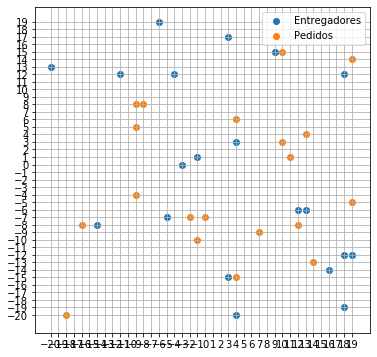

In [0]:
plt.figure(figsize=(6,6))
plt.scatter(entregadores[:,0], entregadores[:,1], label = "Entregadores")
plt.scatter(pedidos[:,0],pedidos[:,1], label = "Pedidos")
plt.xticks(range(-20, 20))
plt.yticks(range(-20, 20))
plt.legend()
plt.grid()
plt.show()

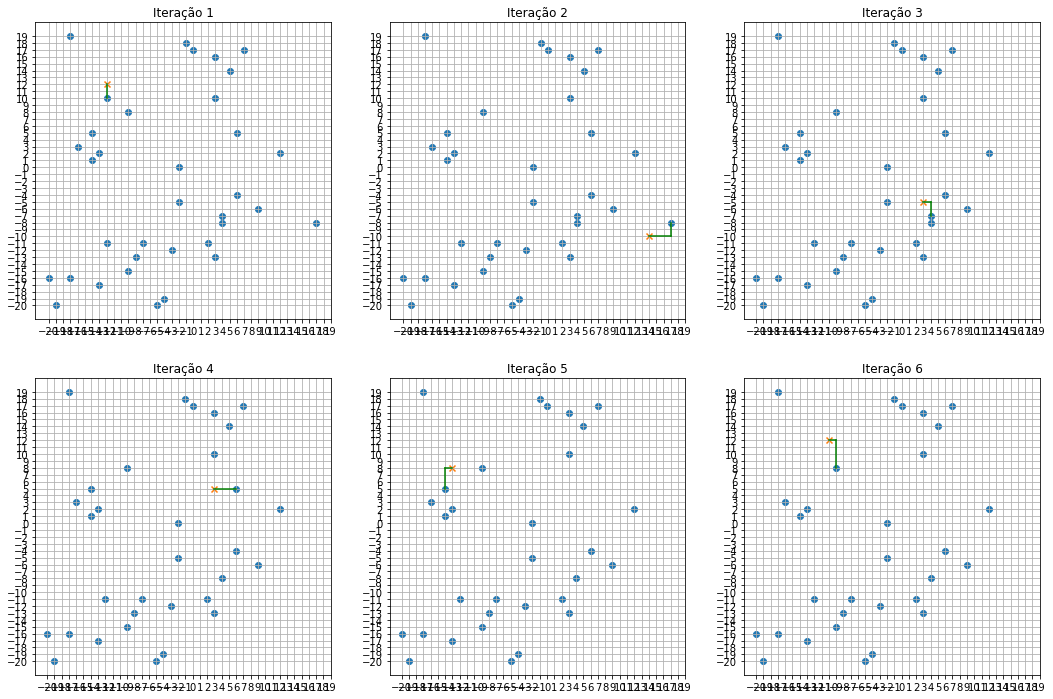

In [0]:
plt.figure(figsize=(18,12))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.title('Iteração {}'.format(i))
    mostraAlocado1(entregadores, pedidos, alocacoes, i-1)

# Programação Linear Inteira

In [0]:
np.random.seed(2)
instantes = np.random.exponential(0.4, nPedidos)
instantes = np.array([sum(instantes[:(i+1)]) for i in range(nPedidos)])
m = int(instantes[-1]) + 1

In [0]:
def pedidosIntervalo(pedidos, instantes, a, b):
    return pedidos[(instantes >= a) & (instantes < b), :]

def montaPL(entregadores, pedidos):
    n, m = len(entregadores), len(pedidos)
    X = cx.Variable(shape=(n, m), boolean=True)
    constraints = [
        cx.sum(X, axis=1) <= 1,
        cx.sum(X, axis=0) <= 1,
        cx.sum(X) == min(n, m)
    ]
    
    distancias = dist.cdist(entregadores, pedidos, metric="cityblock")
    
    obj = cx.Minimize(sum([sum([X[i, j] * distancias[i, j] for i in range(n)]) for j in range(m)]))
    return cx.Problem(obj, constraints=constraints)

def despacha(entregadores, disponiveis, pedidos, instantes, a, b):
    n = len(disponiveis)
    d2e = np.array(range(n))[disponiveis]
    pedidos_aux = pedidosIntervalo(pedidos, instantes, a, b)
    if len(pedidos_aux) > 0:
        pedidos_antes = len(pedidosIntervalo(pedidos, instantes, 0, a))

        pl = montaPL(entregadores[disponiveis, :], pedidos_aux)
        pl.solve()
        resultado = pl.solution.primal_vars[next(iter(pl.solution.primal_vars.keys()))]

        escolhidos = []
        for i in range(sum(disponiveis)):
            for j in range(len(pedidos_aux)):
                if resultado[i, j] > 1 - 1e-6:
                    escolhidos.append([d2e[i], pedidos_antes + j])
        escolhidos = np.array(escolhidos)
        disponiveis[escolhidos[:, 0]] = False
        return escolhidos, pl.solution.opt_val
    else:
        return np.array([]), 0.

def junta_tudo(entregadores, pedidos, instantes, a, b, steps):
    xs = np.linspace(0, m, steps+1)
    aux = []
    disponiveis = np.array([True for i in range(nEntregadores)])
    escolhidos = []
    distancia_total = 0
    for i in range(steps):
        aux.append(np.copy(disponiveis))
        res, d = despacha(entregadores, disponiveis, pedidos, instantes, xs[i], xs[i+1])
        escolhidos += list(res)
        distancia_total += d
    return np.array(escolhidos), aux, distancia_total

In [0]:
def mostraAlocado(entregadores, pedidos, escolhidos, disponiveis, k):
    plt.scatter(*(entregadores[disponiveis[k], :].T))
    plt.scatter(*(pedidos.T), marker='x')

    for i, j in zip(entregadores[escolhidos[:, 0]], pedidos):
        plt.plot([i[0], i[0]], [i[1], j[1]], 'g')
        plt.plot([i[0], j[0]], [j[1], j[1]], 'g')

    plt.xticks(range(-20, 20))
    plt.yticks(range(-20,20))

    plt.grid();

In [0]:
escolhidos, disponiveis, distancia_total = junta_tudo(entregadores, pedidos, instantes, 0, m, 6)

In [0]:
entregadores_aux = entregadores[escolhidos[:, 0]]
pedidos_aux = pedidos[escolhidos[:, 1]]

print("Distância total percorrida: {}".format(distancia_total))

Distância total percorrida: [261.]


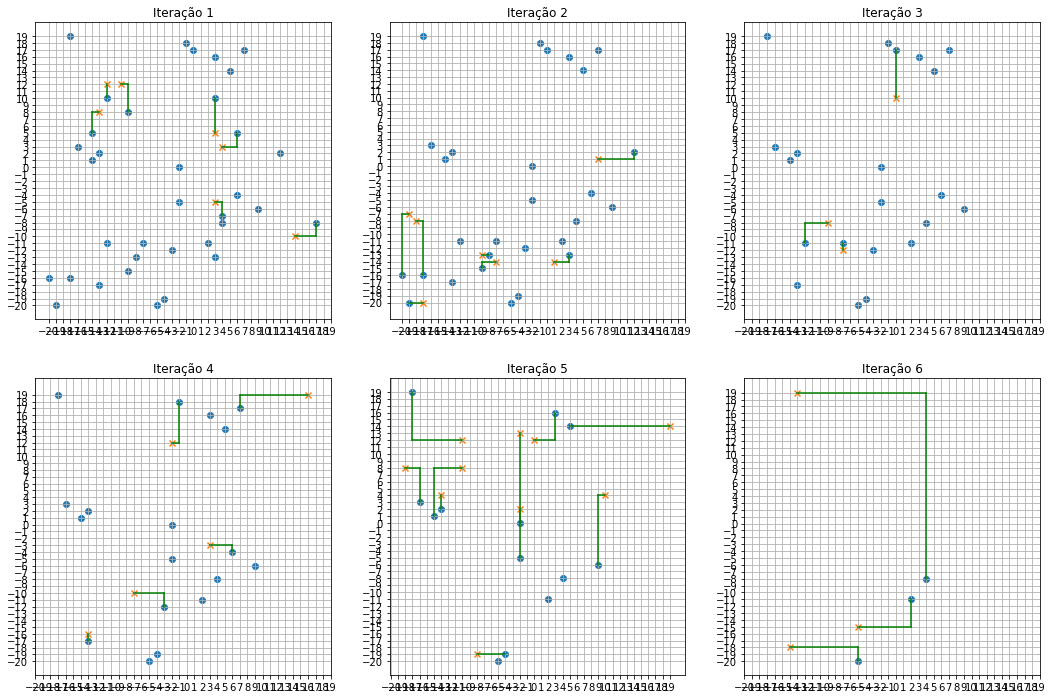

In [0]:
plt.figure(figsize=(18,12))
xs = np.linspace(0, m, 7)
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.title('Iteração {}'.format(i))
    aux = escolhidos[(instantes >= xs[i-1]) & (instantes < xs[i])]
    mostraAlocado(entregadores, pedidos[aux[:, 1]], aux, disponiveis, i-1)

# Monte Carlo

Variando a Quantidade de Lotes


In [0]:
"Veja a necessidade de fazer essa avaliação"

diferenca_algoritmos = []
nEntregadores = 35
nPedidos = 35

for monte_carlo in range(0,100):
    
    disponiveis = np.array([True for i in range(nEntregadores)])
    entregadores = np.random.randint(-20,20, size = (nEntregadores, 2))
    pedidos = np.random.randint(-20,20, size = (nPedidos, 2))
    alocacoes = np.array([aloca(entregadores, disponiveis, i) for i in pedidos])
    distancia_guloso = alocacoes[:, 1].sum()
    
    instantes = np.random.exponential(0.4, nPedidos)
    instantes = np.array([sum(instantes[:(i+1)]) for i in range(nPedidos)])
    m = int(instantes[-1]) + 1
    escolhidos, disponiveis, distancia_plinear = junta_tudo(entregadores, pedidos, instantes, 0, m, 6)
    
    diferenca_algoritmos.append([distancia_guloso,distancia_plinear])

diferenca_algoritmos = np.array(diferenca_algoritmos)

In [0]:
sum((diferenca_algoritmos[:, 0] - diferenca_algoritmos[:, 1]) / diferenca_algoritmos[:, 0]) / 100

array([0.05345965])

In [0]:
diferenca_algoritmos = []
nEntregadores = 35
nPedidos = 35

for monte_carlo in range(0,100):
    
    disponiveis = np.array([True for i in range(nEntregadores)])
    entregadores = np.random.randint(-20,20, size = (nEntregadores, 2))
    pedidos = np.random.randint(-20,20, size = (nPedidos, 2))
    alocacoes = np.array([aloca(entregadores, disponiveis, i) for i in pedidos])
    distancia_guloso = alocacoes[:, 1].sum()
    
    instantes = np.random.exponential(0.4, nPedidos)
    instantes = np.array([sum(instantes[:(i+1)]) for i in range(nPedidos)])
    m = int(instantes[-1]) + 1
    escolhidos, disponiveis, distancia_plinear = junta_tudo(entregadores, pedidos, instantes, 0, m, 6)
    
    diferenca_algoritmos.append([distancia_guloso,distancia_plinear])
    
diferenca_algoritmos = np.array(diferenca_algoritmos)

sum((diferenca_algoritmos[:, 0] - diferenca_algoritmos[:, 1]) / diferenca_algoritmos[:, 0]) / 100

array([0.03684495])

In [0]:
diferenca_algoritmos = []
nEntregadores = 35
nPedidos = 35

for monte_carlo in range(0,100):
    
    disponiveis = np.array([True for i in range(nEntregadores)])
    entregadores = np.random.randint(-20,20, size = (nEntregadores, 2))
    pedidos = np.random.randint(-20,20, size = (nPedidos, 2))
    alocacoes = np.array([aloca(entregadores, disponiveis, i) for i in pedidos])
    distancia_guloso = alocacoes[:, 1].sum()
    
    instantes = np.random.exponential(0.4, nPedidos)
    instantes = np.array([sum(instantes[:(i+1)]) for i in range(nPedidos)])
    m = int(instantes[-1]) + 1
    escolhidos, disponiveis, distancia_plinear = junta_tudo(entregadores, pedidos, instantes, 0, m, 3)
    
    diferenca_algoritmos.append([distancia_guloso,distancia_plinear])
    
diferenca_algoritmos = np.array(diferenca_algoritmos)

sum((diferenca_algoritmos[:, 0] - diferenca_algoritmos[:, 1]) / diferenca_algoritmos[:, 0]) / 100

array([0.10105002])

In [0]:
diferenca_batch = []
nEntregadores = 35
nPedidos = 35

for batch in range(1,11):
    
    diferenca_algoritmos = []
    
    for monte_carlo in range(0,100):
        disponiveis = np.array([True for i in range(nEntregadores)])
        entregadores = np.random.randint(-20,20, size = (nEntregadores, 2))
        pedidos = np.random.randint(-20,20, size = (nPedidos, 2))
        alocacoes = np.array([aloca(entregadores, disponiveis, i) for i in pedidos])
        distancia_guloso = alocacoes[:, 1].sum()

        instantes = np.random.exponential(0.4, nPedidos)
        instantes = np.array([sum(instantes[:(i+1)]) for i in range(nPedidos)])
        m = int(instantes[-1]) + 1
        escolhidos, disponiveis, distancia_plinear = junta_tudo(entregadores, pedidos, instantes, 0, m, batch)
        diferenca_algoritmos.append([distancia_guloso,distancia_plinear])
    diferenca_algoritmos = np.array(diferenca_algoritmos)
    diferenca_batch.append([sum((diferenca_algoritmos[:, 0] - diferenca_algoritmos[:, 1]) / diferenca_algoritmos[:, 0]) / 100,batch])
    

In [0]:
diferenca_batch

[[array([0.22362737]), 1],
 [array([0.14686613]), 2],
 [array([0.10512779]), 3],
 [array([0.08174715]), 4],
 [array([0.06414078]), 5],
 [array([0.05278157]), 6],
 [array([0.03981655]), 7],
 [array([0.04797057]), 8],
 [array([0.03434059]), 9],
 [array([0.03881512]), 10]]

In [0]:
np.array(diferenca_batch)[:,0]

array([array([0.22362737]), array([0.14686613]), array([0.10512779]),
       array([0.08174715]), array([0.06414078]), array([0.05278157]),
       array([0.03981655]), array([0.04797057]), array([0.03434059]),
       array([0.03881512])], dtype=object)

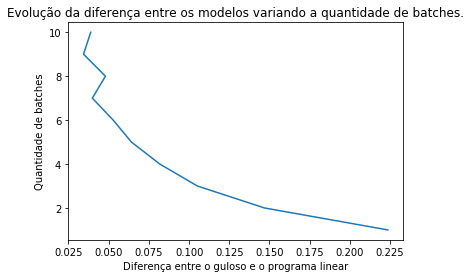

In [0]:
plt.plot(np.array(diferenca_batch)[:,0],np.array(diferenca_batch)[:,1])
plt.title("Evolução da diferença entre os modelos variando a quantidade de batches.")
plt.xlabel("Diferença entre o guloso e o programa linear")
plt.ylabel("Quantidade de batches")
plt.show()

Veja a Necessidade de Avaliarmos Variação da proporção de entregadores e pedidos. 

In [0]:
diferenca_algoritmos50_40 = []
nEntregadores = 50
nPedidos = 40

for monte_carlo in range(0,100):
    
    disponiveis = np.array([True for i in range(nEntregadores)])
    entregadores = np.random.randint(-20,20, size = (nEntregadores, 2))
    pedidos = np.random.randint(-20,20, size = (nPedidos, 2))
    alocacoes = np.array([aloca(entregadores, disponiveis, i) for i in pedidos])
    distancia_guloso = alocacoes[:, 1].sum()
    
    instantes = np.random.exponential(0.4, nPedidos)
    instantes = np.array([sum(instantes[:(i+1)]) for i in range(nPedidos)])
    m = int(instantes[-1]) + 1
    escolhidos, disponiveis, distancia_plinear = junta_tudo(entregadores, pedidos, instantes, 0, m, 6)
    
    diferenca_algoritmos50_40.append([distancia_guloso,distancia_plinear])
    
diferenca_algoritmos50_40 = np.array(diferenca_algoritmos50_40)

In [0]:
diferenca_proporcao = []
entregadores_pedidos = np.array([[50,50],[50,40],[40,30],[30,20],[50,30],[20,10],[30,10],[40,10],[50,10]])

for par in entregadores_pedidos:
  nEntregadores = par[0]
  nPedidos = par[1]
  diferenca_algoritmos = []
  for monte_carlo in range(0,100):
    disponiveis = np.array([True for i in range(nEntregadores)])
    entregadores = np.random.randint(-20,20, size = (nEntregadores, 2))
    pedidos = np.random.randint(-20,20, size = (nPedidos, 2))
    alocacoes = np.array([aloca(entregadores, disponiveis, i) for i in pedidos])
    distancia_guloso = alocacoes[:, 1].sum()

    instantes = np.random.exponential(0.4, nPedidos)
    instantes = np.array([sum(instantes[:(i+1)]) for i in range(nPedidos)])
    m = int(instantes[-1]) + 1
    escolhidos, disponiveis, distancia_plinear = junta_tudo(entregadores, pedidos, instantes, 0, m, 3)
    diferenca_algoritmos.append([distancia_guloso,distancia_plinear])
  diferenca_algoritmos = np.array(diferenca_algoritmos)
  diferenca_proporcao.append([sum((diferenca_algoritmos[:, 0] - diferenca_algoritmos[:, 1]) / diferenca_algoritmos[:, 0]) / 100,nPedidos/nEntregadores])

In [0]:
diferenca_proporcao

[[array([0.11078839]), 1.0],
 [array([0.06189019]), 0.8],
 [array([0.05050247]), 0.75],
 [array([0.03730054]), 0.6666666666666666],
 [array([0.03163583]), 0.6],
 [array([0.02480848]), 0.5],
 [array([0.01622941]), 0.3333333333333333],
 [array([0.0069524]), 0.25],
 [array([0.00794202]), 0.2]]

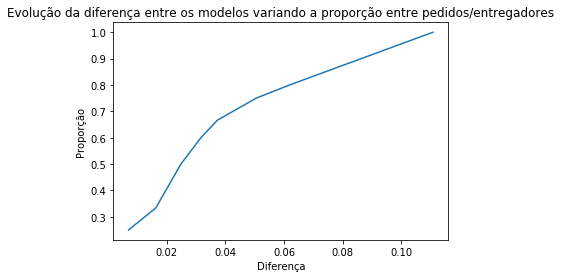

In [0]:
plt.plot(np.array(diferenca_proporcao)[:-1,0],np.array(diferenca_proporcao)[:-1,1])
plt.title("Evolução da diferença entre os modelos variando a proporção entre pedidos/entregadores")
plt.xlabel("Diferença")
plt.ylabel("Proporção")
plt.show()

Veja necessidade de avaliarmos alteração da quantidade de entregadores ou pedidos TOTAL

In [0]:
diferenca = []
entregadores_pedidos = np.array([[60,60],[50,50],[40,40],[30,30],[20,20],[10,10]])

for par in entregadores_pedidos:
  nEntregadores = par[0]
  nPedidos = par[1]
  diferenca_algoritmos = []
  for monte_carlo in range(0,100):
    disponiveis = np.array([True for i in range(nEntregadores)])
    entregadores = np.random.randint(-20,20, size = (nEntregadores, 2))
    pedidos = np.random.randint(-20,20, size = (nPedidos, 2))
    alocacoes = np.array([aloca(entregadores, disponiveis, i) for i in pedidos])
    distancia_guloso = alocacoes[:, 1].sum()

    instantes = np.random.exponential(0.4, nPedidos)
    instantes = np.array([sum(instantes[:(i+1)]) for i in range(nPedidos)])
    m = int(instantes[-1]) + 1
    escolhidos, disponiveis, distancia_plinear = junta_tudo(entregadores, pedidos, instantes, 0, m, 3)
    diferenca_algoritmos.append([distancia_guloso,distancia_plinear])
  diferenca_algoritmos = np.array(diferenca_algoritmos)
  diferenca.append([sum((diferenca_algoritmos[:, 0] - diferenca_algoritmos[:, 1]) / diferenca_algoritmos[:, 0]) / 100,nEntregadores])

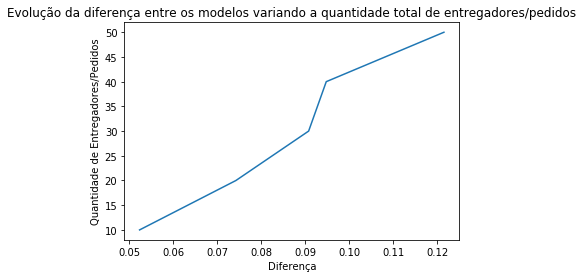

In [0]:
plt.plot(np.array(diferenca)[1:,0],np.array(diferenca)[1:,1])
plt.title("Evolução da diferença entre os modelos variando a quantidade total de entregadores/pedidos")
plt.xlabel("Diferença")
plt.ylabel("Quantidade de Entregadores/Pedidos")
plt.show()

Variando o parâmetro das distribuições de probabilidade

In [0]:
diferenca_prob = []
lambdas = np.array([0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1])
nEntregadores = 35
nPedidos = 35

for l in lambdas:
  
  diferenca_algoritmos = []
  for monte_carlo in range(0,100):
    disponiveis = np.array([True for i in range(nEntregadores)])
    entregadores = np.random.randint(-20,20, size = (nEntregadores, 2))
    pedidos = np.random.randint(-20,20, size = (nPedidos, 2))
    alocacoes = np.array([aloca(entregadores, disponiveis, i) for i in pedidos])
    distancia_guloso = alocacoes[:, 1].sum()

    instantes = np.random.exponential(l, nPedidos)
    instantes = np.array([sum(instantes[:(i+1)]) for i in range(nPedidos)])
    m = int(instantes[-1]) + 1
    escolhidos, disponiveis, distancia_plinear = junta_tudo(entregadores, pedidos, instantes, 0, m, 3)
    diferenca_algoritmos.append([distancia_guloso,distancia_plinear])
  diferenca_algoritmos = np.array(diferenca_algoritmos)
  diferenca_prob.append([sum((diferenca_algoritmos[:, 0] - diferenca_algoritmos[:, 1]) / diferenca_algoritmos[:, 0]) / 100,l])

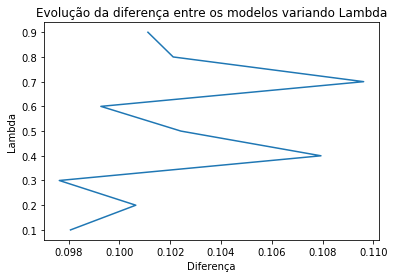

In [0]:
plt.plot(np.array(diferenca_prob)[:,0],np.array(diferenca_prob)[:,1])
plt.title("Evolução da diferença entre os modelos variando Lambda")
plt.xlabel("Diferença")
plt.ylabel("Lambda")
plt.show()